18960
Mean Squared Error (MSE): 0.34001504875009325
R-squared (R2): 0.8400819793741989
Mean Absolute Error (MAE): 0.20379562854485778
Feature: CO2_SS_1_last_lag_5, Importance: 0.4104986134003385
Feature: CO2_SS_1_last_lag_30, Importance: 0.10670060177558766
Feature: CO2_SS_1_last_lag_10, Importance: 0.10189330415165074
Feature: CO2_SS_1_last_lag_15, Importance: 0.08123979701273029
Feature: CO2_SS_1_last_lag_50, Importance: 0.06894114776058208
Feature: CO2_SS_1_last_lag_25, Importance: 0.05503186048524381
Feature: CO2_SS_1_last_lag_20, Importance: 0.050608275538663684
Feature: CO2_SS_1_last_lag_45, Importance: 0.04441281064104152
Feature: CO2_SS_1_last_lag_35, Importance: 0.04285218011205453
Feature: CO2_SS_1_last_lag_40, Importance: 0.037821409122107234


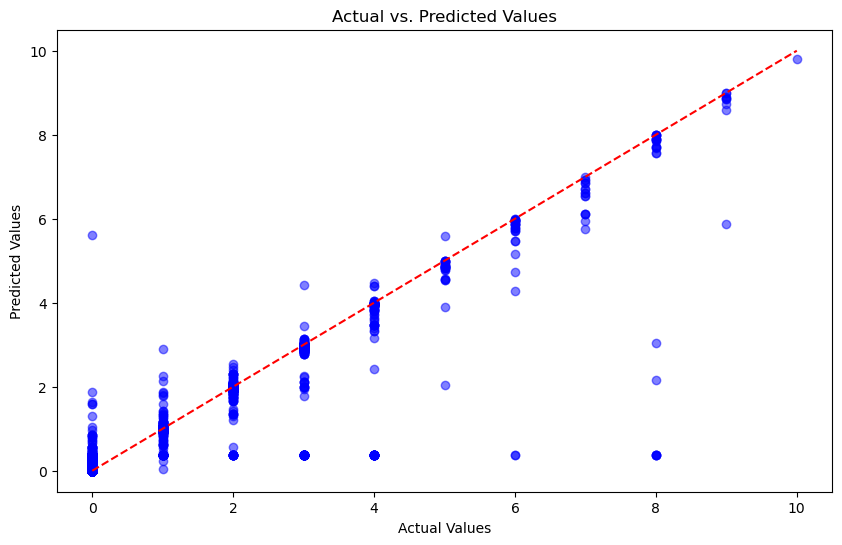

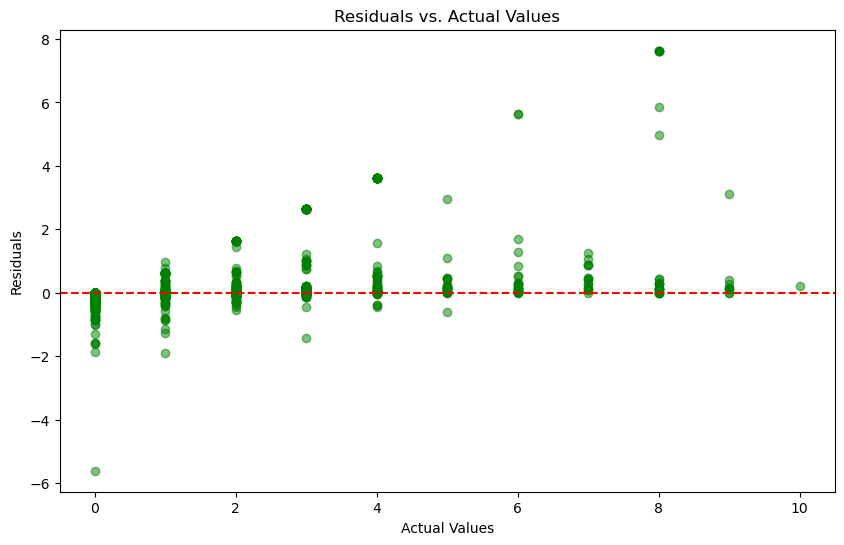

In [1]:
#Tampere Autoregression
#CO2 only performs the best

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Load your data from 'data.csv'
df = pd.read_csv('Tampere/C0EA_edited_headings_final_tampere_28th_Nov_filtered_combined.csv', delimiter=",")

# Drop useless columns
drop_columns = ['MOVEMENT_ONBOARD_min', 'MOVEMENT_ONBOARD_max', 'MOVEMENT_ONBOARD_avg']
df = df.drop(columns=drop_columns)
print(len(df))
# Convert 'Datetime' column to datetime format with dayfirst=True
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the rate of change for the specified columns
rate_interest = ['VOC_ONBOARD_last', 'VOC_ONBOARD_min', 'VOC_ONBOARD_max', 'VOC_ONBOARD_avg',
                'CO2_SS_1_avg', 'CO2_SS_1_min', 'CO2_SS_1_max', 'CO2_SS_1_last',  'DBC_ONBOARD_max', 'DBC_ONBOARD_min', 'DBC_ONBOARD_avg', 'DBC_ONBOARD_last']
df[rate_interest] = df[rate_interest].replace(',', '.', regex=True).astype(float)

#Convert string columns to numeric
df['VOC_ONBOARD_max'] = pd.to_numeric(df['VOC_ONBOARD_max'], errors='coerce')
df['VOC_ONBOARD_min'] = pd.to_numeric(df['VOC_ONBOARD_min'], errors='coerce')
df['VOC_ONBOARD_last'] = pd.to_numeric(df['VOC_ONBOARD_last'], errors='coerce')

df['CO2_SS_1_max'] = pd.to_numeric(df['CO2_SS_1_max'], errors='coerce')
df['CO2_SS_1_min'] = pd.to_numeric(df['CO2_SS_1_min'], errors='coerce')
df['CO2_SS_1_last'] = pd.to_numeric(df['CO2_SS_1_last'], errors='coerce')
df['CO2_range'] = df['CO2_SS_1_max'] - df['CO2_SS_1_min']
df['VOC_range'] = df['VOC_ONBOARD_max'] - df['VOC_ONBOARD_min']

#Convert string columns to numeric
df['DBC_ONBOARD_max'] = pd.to_numeric(df['DBC_ONBOARD_max'], errors='coerce')
df['DBC_ONBOARD_min'] = pd.to_numeric(df['DBC_ONBOARD_min'], errors='coerce')
df['DBC_ONBOARD_last'] = pd.to_numeric(df['DBC_ONBOARD_last'], errors='coerce')
df['DBC_range'] = df['DBC_ONBOARD_max'] - df['DBC_ONBOARD_min']

auto_reg_sources = ['CO2_SS_1_last' ] #['VOC_ONBOARD_last' ]  #['CO2_SS_1_last' ]  # Define the target columns for lagged features

# Define lag combinations
lag_combinations = [
     [5, 10, 15,20,25,30,35,40,45,50],
    # Add more combinations as needed
]

for lag_values in lag_combinations:  # Loop through different lag combinations
    for auto_reg_source in auto_reg_sources:
        for lag in lag_values:
            df[f'{auto_reg_source}_lag_{lag}'] = df[auto_reg_source].shift(lag)

    # Drop rows with NaN values after creating lagged features
    df.dropna(inplace=True)

    # Create a list of feature columns with lagged values
    lag_columns = [f'{auto_reg_source}_lag_{lag}' for auto_reg_source in auto_reg_sources for lag in lag_values]
    feature_columns = lag_columns  #+['MOVEMENT_ONBOARD_last']  # Include the original column without lag

    # Replace commas (,) with periods (.) in feature columns and convert to float
    df[feature_columns] = df[feature_columns].replace(',', '.', regex=True).astype(float)

    # Specify the target column
    target_column ="CO2_SS_1_Inferred Occupancy" #'VOC_ONBOARD_Inferred Occupancy' #

    # Split the data into features (X) and target (y)
    X = df[feature_columns]
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the model (Random Forest Regressor)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error (MSE) and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)

    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Error (MAE):", mae)

    # Get the feature names and their importance values
    feature_importance_pairs = list(zip(feature_columns, model.feature_importances_))
    # Sort the feature importance pairs by importance (in descending order)
    sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    # Print feature names and their importance values
    for feature_name, importance in sorted_feature_importance_pairs:
        print(f"Feature: {feature_name}, Importance: {importance}")

    # Plot predicted values vs. actual values vs. residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='b', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.savefig('figures/performance_Rf_auto_CO2_Tampere.png')
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, c='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Actual Values")
    plt.savefig('figures/residual_Rf_auto_CO2_Tampere.png')
    plt.show()

    from joblib import dump
    # Uncomment to save the model
    #dump(model, 'RF_autoregressor_co2_last_pir_Tampere.joblib')
